In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io.wavfile import write
import librosa 



Learning Outcome: The student will understand what a spectrogram is and the bridge between the FFT. They will clarify why spectograms are useful for analysing signals and how different window frames affect the output of the short term fourier transform.

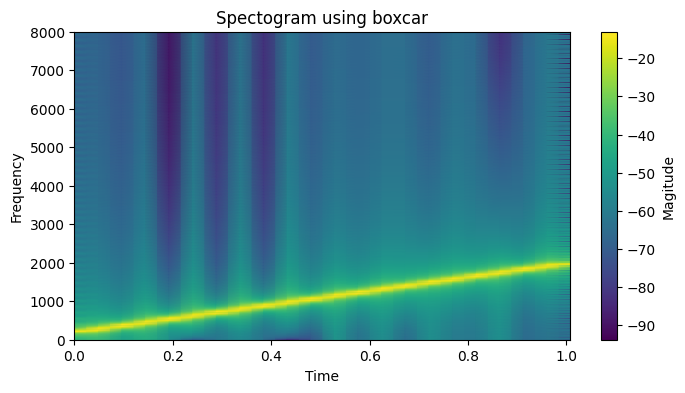

In [20]:
Fs = 16000
dur = 1.0
t = np.linspace(0, dur, int(Fs*dur), endpoint=False)
window_type = 'boxcar'
#TODO create a linear chirp signal, starting at a particular frequncy and rising linearly
x = signal.chirp(t, f0=200, f1=2000, t1=dur, method='linear')

nperseg = 1024 #This is the number of samples
noverlap = nperseg//4 #This represents the percentage overlap

#TODO Try different window types and compute the spectogram
f, tt, Zxx = signal.stft(x, fs=Fs, nperseg=nperseg, noverlap=noverlap, window=window_type)
#TODO Plot the spectogram with the different window types
plt.figure(figsize=(8,4))
plt.pcolormesh(tt, f, 20*np.log10(np.abs(Zxx)+1e-6), shading='gouraud')
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.title(f'Spectogram using {window_type}')
plt.colorbar(label='Magitude')
plt.show()

1) What difference do you notice in the sharpness and smoothness of the chirp line as you change the window? Explain how the window length and shape affect frequency resolution and time resolution.

Learning Outcomes: Use real audio such as a piano song to observe the frequencies that the signal is composed of. The student will observe and match the audio with the spectrogram which will clarify their understanding. In addition they will filter and alter the audio by using the inverse FFT and then listen to the affect of masking different frequencies. The students should be encouraged to use a piece fo music which they enjoy and recognise to observe the effects of signal filtering clearly.

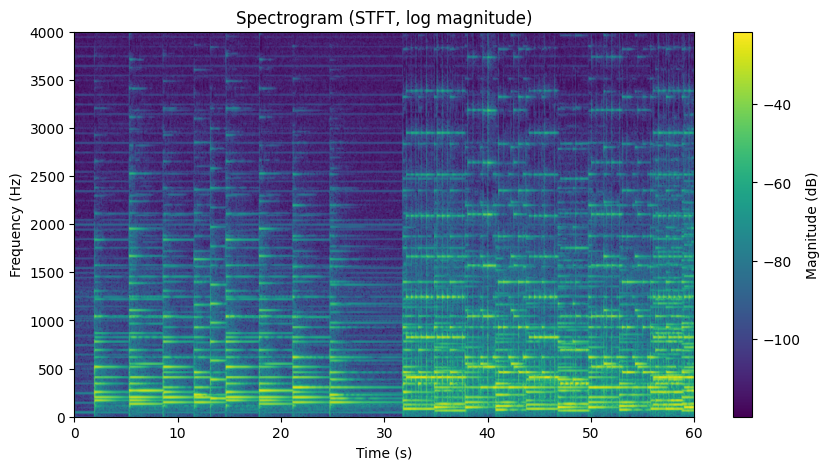

Reconstruction relative error: 5.243e-16


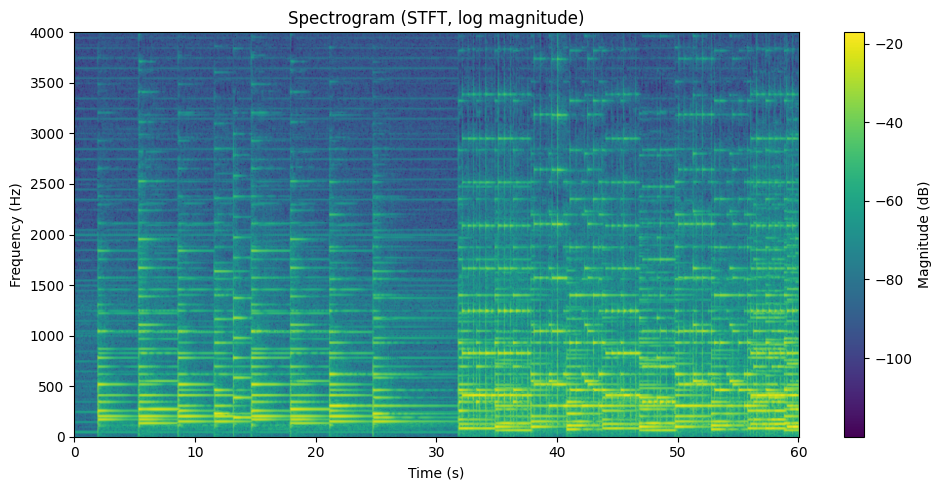

Saved enhanced_output.wav


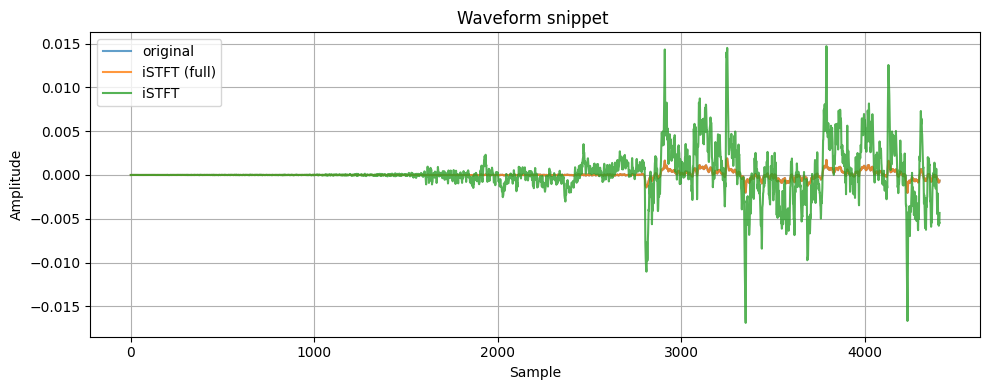

In [21]:

AUDIO_PATH = "/Users/jackhilton-jones/demonstrating/dsp/labs/digital_signal_processing_labs/286.mp3"  # change to a .wav or .mp3 on your machine

def load_audio(path):
    try:
        y, fs = librosa.load(path, sr=None, mono=True)
        return fs, y.astype(np.float64)
    except Exception:
        fs = 16_000
        t = np.linspace(0, 2.0, int(fs*2.0), endpoint=False)
        y = signal.chirp(t, f0=200, f1=2000, t1=2.0, method="linear")
        print("Note: could not read file; using a synthetic chirp instead.")
        return fs, y

fs, y = load_audio(AUDIO_PATH)

Tmax = min(len(y)/fs, 60.0)
y = y[:int(Tmax*fs)]

#TODO Compute and create a spectogram
nperseg = min(5000, len(y))           
noverlap = nperseg//4  
window = "hann"

f, t, Zxx = signal.stft(
    y, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap,
)

# TODO Plot log-spectrogram 
plt.figure(figsize=(10, 5))
plt.pcolormesh(t, f, 20*np.log10(np.abs(Zxx)+1e-6), shading="gouraud")
plt.colorbar(label="Magnitude (dB)")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Spectrogram (STFT, log magnitude)")
plt.ylim(0, min(4000, fs/2))  
plt.show()

# TODO Invert the spectogram
t_rec, y_rec = signal.istft(
    Zxx, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap
)

# TODO pad/truncate to original length for error metric
N = min(len(y), len(y_rec))
err = np.linalg.norm(y[:N] - y_rec[:N]) / (np.linalg.norm(y[:N]) + 1e-12)
print(f"Reconstruction relative error: {err:.3e}")

# TODO enhance the magnitude of the original signal by 0.8 and 1.2
mag = np.abs(Zxx)
phase = np.angle(Zxx)
mag_enhanced = mag ** .8
Z_enhanced = mag_enhanced * np.exp(1j * phase)

# TODO plot the new spectogram
plt.figure(figsize=(10, 5))
plt.pcolormesh(t, f, 20*np.log10(np.abs(Z_enhanced)+1e-6), shading="gouraud")
plt.colorbar(label="Magnitude (dB)")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Spectrogram (STFT, log magnitude)")
plt.ylim(0, min(4000, fs/2)) 
plt.tight_layout()
plt.show()


_, y_band = signal.istft(Z_enhanced, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap)
# Convert to 16-bit PCM
y_out_int16 = np.int16(y_band * 32767)
# Write to .wav file
write("enhanced_output.wav", fs, y_out_int16)
print("Saved enhanced_output.wav")


Nb = min(len(y), len(y_band))
err_band = np.linalg.norm(y[:Nb] - y_band[:Nb]) / (np.linalg.norm(y[:Nb]) + 1e-12)
sec = 0.1
M = int(sec*fs)
plt.figure(figsize=(10,4))
plt.plot(y[:M], label="original", alpha=0.7)
plt.plot(y_rec[:M], label="iSTFT (full)", alpha=0.8)
plt.plot(y_band[:M], label="iSTFT ", alpha=0.8)
plt.title("Waveform snippet ")
plt.xlabel("Sample"); plt.ylabel("Amplitude"); plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()


Apply spectral gamma with 0.8 and 1.2, reconstruct audio, RMS-normalize both to the original, and compare spectrograms and short waveform snippets.
1) Which gamma compresses vs expands spectral dynamic range? Describe audible changes and relate them to changes you observe in the spectrogram.

Learning Outcomes: The aim is to provide a clear understanding of modulation and the difference between AM and FM. This practice is concise to allow a practical implementation of a carrier and message frequency.

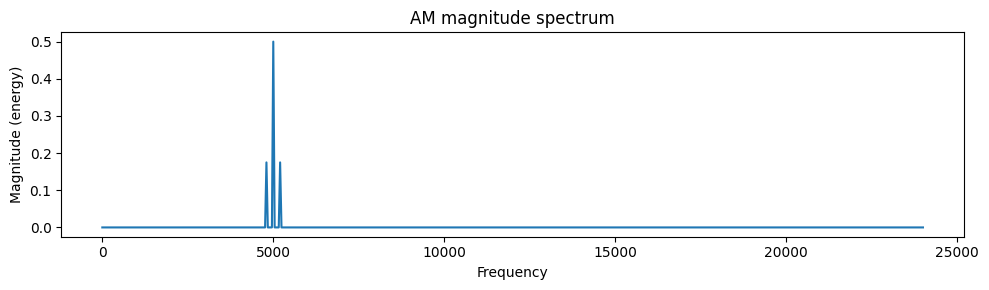

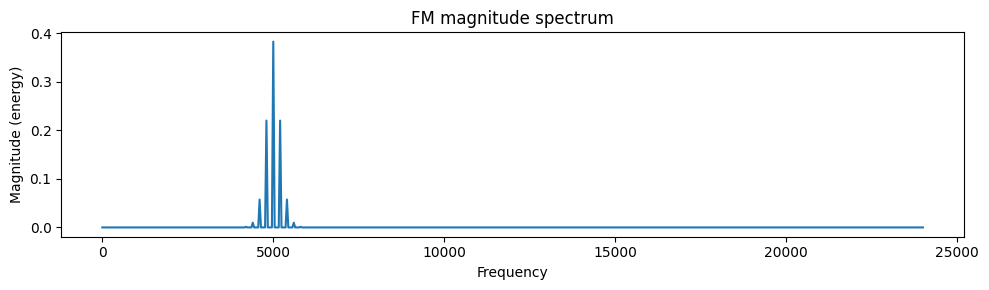

In [22]:

Fs = 48_000
T  = 0.05
t  = np.linspace(0, T, int(Fs*T), endpoint=False)


fm = 200.0                        # message frequency
m  = np.sin(2*np.pi*fm*t)         # message 

fc = 5000.0                      # carrier
carrier = np.cos(2*np.pi*fc*t)

#TODO compute the amplitude modulation
mu   = 0.7 # modulation depth
s_am = (1 + mu*m) * carrier

#TODO compute the frequency modulation
Df   = 200                  # peak frequency deviation 
beta = Df / fm                    # modulation index
s_fm = np.cos(2*np.pi*fc*t + beta*np.sin(2*np.pi*fm*t))

#TODO plot the amplitude modulation
plt.figure(figsize=(10,3))
plt.magnitude_spectrum(s_am, Fs=Fs); plt.title('AM magnitude spectrum'); plt.tight_layout(); plt.show()
#TODO plot the frequency modulation
plt.figure(figsize=(10,3))
plt.magnitude_spectrum(s_fm, Fs=Fs); plt.title('FM magnitude spectrum'); plt.tight_layout(); plt.show()



Explain why the FM spectrum is wider even though the message frequency is the same as in AM.

Learning Outcomes: The student should record their own voice for the voiced and unvoiced phonemes and use this audio to compute the zero crossing rate. The zero crossing rate and energy of the signal will demonstrate the difference between voiced and unvoiced phonemes by the signal oscillation.

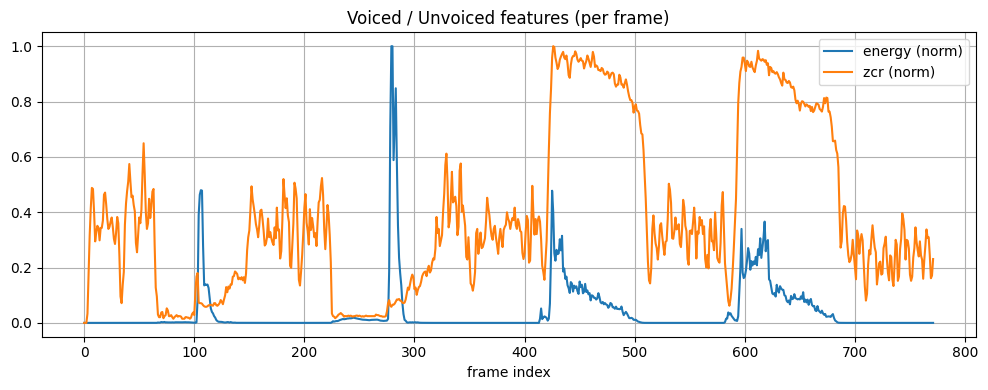

In [27]:
AUDIO_PATH = "/Users/jackhilton-jones/demonstrating/dsp/labs/digital_signal_processing_labs/AbbottsWay3.wav"  
def load_audio(path):
    if path is None:
        fs = 16000
        dur = 2.0
        t = np.linspace(0, dur, int(fs*dur), endpoint=False)
        vowel = np.sin(2*np.pi*180*t) + 0.5*np.sin(2*np.pi*360*t)
        noise = 0.15*np.random.randn(t.size)
        fric = (t>0.9)&(t<1.1)
        x = vowel*(t<0.9) + (0.6*np.random.randn(t.size))*fric + 0.2*noise
        return fs, x.astype(float)
    else:
        try:
            y, fs = librosa.load(path, sr=None, mono=True)
            return fs, y.astype(float)
        except Exception:
            print("Could not read file; falling back to synthetic.")
            return load_audio(None)

# TODO Upload your audio of voiced vs unvoiced phonemes
fs, x = load_audio(AUDIO_PATH)


frame_ms = 25
hop_ms   = 10
Nf = int(fs*frame_ms/1000)
H  = int(fs*hop_ms/1000)
win = np.hanning(Nf)

#TODO iterate through a for loop to compute the hanns frame
frames = []
for start in range(0, max(len(x)-Nf+1, 1), H):
    frames.append(x[start:start+Nf]*win if start+Nf<=len(x) else x[start:len(x)]*np.hanning(len(x)-start))
frames = [f if len(f)==Nf else np.pad(f,(0,Nf-len(f))) for f in frames]
F = np.vstack(frames) 

#TODO Compute the energy and the zcr and plot this
energy = np.sum(F**2, axis=1)
zcr = np.mean(np.abs(np.diff(np.sign(F), axis=1))>0, axis=1)

plt.figure(figsize=(10,4))
plt.plot(energy/energy.max(), label='energy (norm)')
plt.plot(zcr/zcr.max(), label='zcr (norm)')
plt.title("Voiced / Unvoiced features (per frame)")
plt.xlabel("frame index"); plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()


Identify areas on the graph that are voiced and unvoiced phonemes and briefly explain why this is.
